In [7]:
!pip install -qq einops

In [8]:
import warnings
warnings.filterwarnings('ignore')

import os
import gc
from typing import List, Iterable

from IPython.display import clear_output
gc.enable()

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision.ops import StochasticDepth

from einops import rearrange

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import cv2
from PIL import Image, ImageDraw

from sklearn.model_selection import train_test_split

import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

from tqdm.notebook import tqdm
from glob import glob

seed = 42
pd.set_option('display.max_colwidth', None)

In [9]:
def seed_everything(seed=42):
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True
    
seed_everything()

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Currently using "{device.upper()}" device.')

Currently using "CUDA" device.


In [10]:
BATCH_SIZE = 8
IMAGE_SIZE = 224
EPOCHS = 50
NUM_CLASSES = 1  

**Sample image with GT mask**

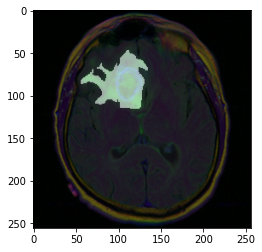

In [5]:
mask = Image.open("../input/lgg-mri-segmentation/kaggle_3m/TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_13_mask.tif")
mask = np.array(mask)[..., np.newaxis]
mask = np.repeat(mask, 3, axis=-1)

image = Image.open("../input/lgg-mri-segmentation/kaggle_3m/TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_13.tif")
image = np.array(image)

image = cv2.addWeighted(image, 0.5, mask, 0.5, 0)

plt.imshow(image)
plt.show()

**Collect images and corresponding masks**

In [11]:
all_paths = glob("../input/lgg-mri-segmentation/kaggle_3m/*/*.tif")
images_paths = sorted([path for path in all_paths if "mask" not in path])
masks_paths = sorted([path[:-9] for path in all_paths if "mask" in path])
masks_paths = [path + "_mask.tif" for path in masks_paths]
del all_paths; gc.collect()

15

In [12]:
data = pd.DataFrame(data={"image": images_paths, "mask": masks_paths})

x_train, x_valid = train_test_split(data, test_size=500, shuffle=True, random_state=seed)
x_test, x_valid = train_test_split(x_valid, test_size=0.5, shuffle=True, random_state=seed)
x_train = x_train.reset_index(drop=True)
x_valid = x_valid.reset_index(drop=True)
x_test = x_test.reset_index(drop=True)

print(f"Train size: {x_train.shape[0]}, validation size: {x_valid.shape[0]}, test size: {x_test.shape[0]}")

Train size: 3429, validation size: 250, test size: 250


In [8]:
x_train.sample(5)

image  \
578   ../input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_5872_19950223/TCGA_DU_5872_19950223_38.tif   
1055  ../input/lgg-mri-segmentation/kaggle_3m/TCGA_HT_7690_19960312/TCGA_HT_7690_19960312_11.tif   
564   ../input/lgg-mri-segmentation/kaggle_3m/TCGA_HT_7881_19981015/TCGA_HT_7881_19981015_40.tif   
2298  ../input/lgg-mri-segmentation/kaggle_3m/TCGA_HT_7686_19950629/TCGA_HT_7686_19950629_14.tif   
3243  ../input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_6401_19831001/TCGA_DU_6401_19831001_44.tif   

                                                                                                 mask  
578   ../input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_5872_19950223/TCGA_DU_5872_19950223_38_mask.tif  
1055  ../input/lgg-mri-segmentation/kaggle_3m/TCGA_HT_7690_19960312/TCGA_HT_7690_19960312_11_mask.tif  
564   ../input/lgg-mri-segmentation/kaggle_3m/TCGA_HT_7881_19981015/TCGA_HT_7881_19981015_40_mask.tif  
2298  ../input/lgg-mri-segmentation/kaggle_3m/TCGA_HT_7686_19950629/TCGA_HT_7686_19950629_14_mask.tif  
3243  ../input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_6401_19831001/TCGA_DU_6401_19831001_44_mask.tif

**Dataset, augmentations, dataloader**

In [13]:
train_transforms = A.Compose([
                      A.OneOf([A.HueSaturationValue(hue_shift_limit=0.2, 
                                                    sat_shift_limit=0.2, 
                                                    val_shift_limit=0.2, 
                                                    p=0.2),      
                      A.RandomBrightnessContrast(brightness_limit=0.2, 
                                                 contrast_limit=0.2, 
                                                 p=0.9)],p=0.2),
                      A.ToGray(p=0.1),
                      A.OneOf(
                              [A.HorizontalFlip(p=0.5),
                               A.VerticalFlip(p=0.5),
                               A.RandomRotate90(p=0.5),
                               A.Transpose(p=0.5),
                              ], p=0.5),
                      A.OneOf([
                                A.ElasticTransform(p=0.5, alpha=120, sigma=120 * 0.05, alpha_affine=120 * 0.03),
                                A.GridDistortion(p=0.5),
                                A.OpticalDistortion(distort_limit=1, shift_limit=0.5, p=1),
                            ], p=0.8),
                      A.Resize(height=IMAGE_SIZE, width=IMAGE_SIZE, p=1),
                      A.Cutout(num_holes=8, max_h_size=10, max_w_size=10, fill_value=0, p=0.1),
                      A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), max_pixel_value=255.0),
                      ToTensorV2(p=1.0),
                      ], p=1.0)

valid_transforms = A.Compose([
                      A.Resize(height=IMAGE_SIZE, width=IMAGE_SIZE, p=1),
                      A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), max_pixel_value=255.0),
                      ToTensorV2(p=1.0),
                      ], p=1.0)

invTrans = A.Compose([A.Normalize(mean=[ 0., 0., 0. ],
                                  std=[ 1/0.229, 1/0.224, 1/0.225 ], max_pixel_value=1.0),
                      A.Normalize(mean=[ -0.485, -0.456, -0.406 ],
                                  std=[ 1., 1., 1. ], max_pixel_value=1.0),
                      ], p=1.0)

def inverse_transforms(tensor):
    if tensor.size(0) == 1 and len(tensor.shape) == 4:
        tensor.squeeze_(0)
    sample = {"image": tensor.cpu().detach().numpy().transpose(1,2,0)}
    image = invTrans(**sample)["image"]

    return image

In [14]:
class SegDataset(Dataset):
    def __init__(self, data, transforms):
        self.data = data
        self.transforms = transforms
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, ix):
        row = self.data.loc[ix].squeeze()
        image = Image.open(row["image"])
        image = np.array(image)
        
        mask = Image.open(row["mask"])
        mask = np.array(mask)
        
        mask = np.where(mask > 127, 255, 0)
        
        sample = {"image": image, "mask": mask}
        sample = self.transforms(**sample)
        
        image, mask = sample["image"], sample["mask"]
        mask = mask[None, ...]
        
        return image, mask / 255.
    
    def collate_fn(self, batch):
        images, masks = list(zip(*batch))
        images, masks = [[tensor[None].to(device) for tensor in btc] for btc in [images, masks]]
        images, masks = [torch.cat(tensors) for tensors in [images, masks]]
        return images, masks

In [15]:
train_ds = SegDataset(x_train, train_transforms)
valid_ds = SegDataset(x_valid, valid_transforms)
test_ds = SegDataset(x_test, valid_transforms)

train_dl = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, collate_fn=train_ds.collate_fn)
valid_dl = DataLoader(valid_ds, batch_size=BATCH_SIZE, shuffle=False, collate_fn=valid_ds.collate_fn)
test_dl = DataLoader(test_ds, batch_size=1, shuffle=False, collate_fn=test_ds.collate_fn)

**Model architecture**

<img src=https://production-media.paperswithcode.com/methods/c84b18b5-4329-49fc-a5f2-804ef580a966.png width=1200>

In [16]:
# https://github.com/FrancescoSaverioZuppichini/SegFormer

class LayerNorm2d(nn.LayerNorm):
    """ swap channel dim, apply layer norm and swap back: see https://github.com/pytorch/pytorch/issues/71465 """
    def forward(self, x):
        x = rearrange(x, "b c h w -> b h w c")
        x = super().forward(x)
        x = rearrange(x, "b h w c -> b c h w")
        return x
    
class OverlapPatchMerging(nn.Sequential):
    def __init__(
        self, in_channels: int, out_channels: int, patch_size: int, overlap_size: int
    ):
        super(OverlapPatchMerging, self).__init__(
                                        nn.Conv2d(
                                            in_channels,
                                            out_channels,
                                            kernel_size=patch_size,
                                            stride=overlap_size,
                                            padding=patch_size // 2,
                                            bias=False
                                        ),
                                        LayerNorm2d(out_channels)
                                    )

In [17]:
# positional encoding eliminated as for original paper: https://arxiv.org/pdf/2105.15203.pdf

class EfficientMultiHeadAttention(nn.Module):
    def __init__(self, channels: int, reduction_ratio: int = 1, num_heads: int = 8):
        super(EfficientMultiHeadAttention, self).__init__()
        self.reducer = nn.Sequential(
            nn.Conv2d(
                channels, channels, kernel_size=reduction_ratio, stride=reduction_ratio
            ),
            LayerNorm2d(channels),
        )
        self.att = nn.MultiheadAttention(
            channels, num_heads=num_heads, batch_first=True
        )

    def forward(self, x):
        _, _, h, w = x.shape
        reduced_x = self.reducer(x)
        # attention needs tensor of shape (batch, sequence_length, channels)
        reduced_x = rearrange(reduced_x, "b c h w -> b (h w) c")  # K, V 
        x = rearrange(x, "b c h w -> b (h w) c")  # Q
        out = self.att(query=x, key=reduced_x, value=reduced_x)[0]
        # reshape it back to (batch, channels, height, width)
        out = rearrange(out, "b (h w) c -> b c h w", h=h, w=w)
        return out
    
# transformer FFN block, here fully convolutional

class MixMLP(nn.Sequential):
    def __init__(self, channels: int, expansion: int = 4):
        super(MixMLP, self).__init__(
            # linear layer
            nn.Conv2d(channels, channels, kernel_size=1),
            # depth wise conv
            nn.Conv2d(
                    channels,
                    channels * expansion,
                    kernel_size=3,
                    groups=channels,
                    padding=1,
            ),
            nn.GELU(),
            # linear layer
            nn.Conv2d(channels * expansion, channels, kernel_size=1),
        )

In [18]:
class ResidualAdd(nn.Module):
    """ A layer that helps to add&norm MHA and FFN outputs """
    def __init__(self, fn):
        super(ResidualAdd, self).__init__()
        self.fn = fn

    def forward(self, x, **kwargs):
        out = self.fn(x, **kwargs)
        x = x + out
        return x

class SegFormerEncoderBlock(nn.Sequential):
    """ Encoder Block: not quite orthodox as not normalizing after MHA and FFN directly """
    def __init__(
                self,
                channels: int,
                reduction_ratio: int = 1,
                num_heads: int = 8,
                mlp_expansion: int = 4,
                drop_path_prob: float = .0
            ):
        super(SegFormerEncoderBlock, self).__init__(
            ResidualAdd(
                nn.Sequential(
                    LayerNorm2d(channels),
                    EfficientMultiHeadAttention(channels, reduction_ratio, num_heads),
                )
            ),
            ResidualAdd(
                nn.Sequential(
                    LayerNorm2d(channels),
                    MixMLP(channels, expansion=mlp_expansion),
                    StochasticDepth(p=drop_path_prob, mode="batch")  # https://pytorch.org/vision/main/generated/torchvision.ops.stochastic_depth.html
                )
            ),
        )

In [19]:
class SegFormerEncoderStage(nn.Sequential):
    def __init__(
        self,
        in_channels: int,
        out_channels: int,
        patch_size: int,
        overlap_size: int,
        drop_probs: List[int],
        depth: int = 2,
        reduction_ratio: int = 1,
        num_heads: int = 8,
        mlp_expansion: int = 4,
    ):
        super(SegFormerEncoderStage, self).__init__()
        self.overlap_patch_merge = OverlapPatchMerging(
            in_channels, out_channels, patch_size, overlap_size,
        )
        self.blocks = nn.Sequential(
            *[
                SegFormerEncoderBlock(
                    out_channels, reduction_ratio, num_heads, mlp_expansion, drop_probs[i]
                )
                for i in range(depth)
            ]
        )
        self.norm = LayerNorm2d(out_channels)

In [20]:
def chunks(data: Iterable, sizes: List[int]):
    """
    Given an iterable, returns slices using sizes as indices
    """
    curr = 0
    for size in sizes:
        chunk = data[curr: curr + size]
        curr += size
        yield chunk
        
class SegFormerEncoder(nn.Module):
    def __init__(
        self,
        in_channels: int,
        widths: List[int],
        depths: List[int],
        all_num_heads: List[int],
        patch_sizes: List[int],
        overlap_sizes: List[int],
        reduction_ratios: List[int],
        mlp_expansions: List[int],
        drop_prob: float = .0
    ):
        super(SegFormerEncoder, self).__init__()
        # create drop paths probabilities (one for each stage's block)
        drop_probs =  [x.item() for x in torch.linspace(0, drop_prob, sum(depths))]
        self.stages = nn.ModuleList(
            [
                SegFormerEncoderStage(*args)
                for args in zip(
                    [in_channels, *widths],
                    widths,
                    patch_sizes,
                    overlap_sizes,
                    chunks(drop_probs, sizes=depths),
                    depths,
                    reduction_ratios,
                    all_num_heads,
                    mlp_expansions
                )
            ]
        )
        
    def forward(self, x):
        features = []
        for stage in self.stages:
            x = stage(x)
            features.append(x)
        return features

In [21]:
# decoder 
class SegFormerDecoderBlock(nn.Sequential):
    """ upsample """
    def __init__(self, in_channels: int, out_channels: int, scale_factor: int = 2):
        super(SegFormerDecoderBlock, self).__init__(
            nn.UpsamplingBilinear2d(scale_factor=scale_factor),
            nn.Conv2d(in_channels, out_channels, kernel_size=1),
        )
        
class SegFormerDecoder(nn.Module):
    """ takes a list of features and returns a list of new features with the same spatial size and channels """
    def __init__(self, out_channels: int, widths: List[int], scale_factors: List[int]):
        super(SegFormerDecoder, self).__init__()
        self.stages = nn.ModuleList(
            [
                SegFormerDecoderBlock(in_channels, out_channels, scale_factor)
                for in_channels, scale_factor in zip(widths, scale_factors)
            ]
        )
    
    def forward(self, features):
        new_features = []
        for feature, stage in zip(features,self.stages):
            x = stage(feature)
            new_features.append(x)
        return new_features

In [22]:
class SegFormerSegmentationHead(nn.Module):
    def __init__(self, channels: int, num_classes: int, num_features: int = 4):
        super(SegFormerSegmentationHead, self).__init__()
        self.fuse = nn.Sequential(
            nn.Conv2d(channels * num_features, channels, kernel_size=1, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(channels)  # paper
        )
        self.predict = nn.Conv2d(channels, num_classes, kernel_size=1)

    def forward(self, features):
        x = torch.cat(features, dim=1)  # concatenate all features obtained before (they have same spatial dims and channels)
        x = self.fuse(x)  # conv and normalize
        x = self.predict(x)  # get final feature map(s)
        return x

In [23]:
# final model: encoder -> decoder -> head

class SegFormer(nn.Module):
    def __init__(
        self,
        in_channels: int,
        widths: List[int],
        depths: List[int],
        all_num_heads: List[int],
        patch_sizes: List[int],
        overlap_sizes: List[int],
        reduction_ratios: List[int],
        mlp_expansions: List[int],
        decoder_channels: int,
        scale_factors: List[int],
        num_classes: int,
        drop_prob: float = 0.0,
    ):

        super(SegFormer, self).__init__()
        self.encoder = SegFormerEncoder(
            in_channels,
            widths,
            depths,
            all_num_heads,
            patch_sizes,
            overlap_sizes,
            reduction_ratios,
            mlp_expansions,
            drop_prob,
        )
        self.decoder = SegFormerDecoder(decoder_channels, widths[::-1], scale_factors)
        self.head = SegFormerSegmentationHead(
            decoder_channels, num_classes, num_features=len(widths)
        )

    def forward(self, x):
        features = self.encoder(x)
        features = self.decoder(features[::-1])  # in the reverse order
        segmentation = self.head(features)
        return segmentation

In [24]:
# check model
segformer = SegFormer(
    in_channels=3,
    widths=[64, 128, 256, 512],
    depths=[3, 4, 6, 3],
    all_num_heads=[1, 2, 4, 8],
    patch_sizes=[7, 3, 3, 3],
    overlap_sizes=[4, 2, 2, 2],
    reduction_ratios=[8, 4, 2, 1],
    mlp_expansions=[4, 4, 4, 4],
    decoder_channels=256,
    scale_factors=[8, 4, 2, 1],
    num_classes=NUM_CLASSES,
)

segmentation = segformer(torch.randn((1, 3, 224, 224)))
segmentation.shape # torch.Size([1, 2, 56, 56])

torch.Size([1, 1, 56, 56])

**Train / Validation / Visualization functions**

In [38]:
def train_one_batch(data, model, optimizer, criterion, threshold=0.5, pos_only=False):
    model.train()
    images, masks = data
    
    optimizer.zero_grad()
    out = model(images)  # [B, 1, 56, 56]
    # out = nn.functional.interpolate(out, size=masks.shape[-2:], mode="bilinear", align_corners=False)  # [B, 1, 224, 224]
    masks = nn.functional.interpolate(masks, size=out.shape[-2:], mode="bilinear", align_corners=False)  # resize target: maybe loss would be more accurate
    
    # loss = criterion(out, masks)  # [B, 1, 224, 224] of logits and [B, 1, 224, 224] of float zeros and ones
    loss = criterion(out, masks)  # [B, 1, 56, 56] of logits and [B, 1, 56, 56] of float zeros and ones

    loss.backward()
    optimizer.step()
    
    out = (torch.sigmoid(out) >= threshold).to(torch.float32)
    if pos_only and torch.all(torch.any(masks.view(BATCH_SIZE, -1), dim=1)):
        pos_mask = (masks != 0)
    else:
        pos_mask = (masks == masks)
    mask_accuracy = (out[pos_mask] == masks[pos_mask]).float().mean()  # binary accuracy, ignoring negative class
    
    return loss.item(), mask_accuracy.item()

# nn.CrossEntropyLoss()(torch.randn(8,2,224,224), msk.squeeze(1).long())  # [B, 2, 224, 224] and [B, 224, 224]

@torch.no_grad()
def validate_one_batch(data, model, criterion, threshold=0.5, pos_only=False):
    model.eval()
    images, masks = data
    out = model(images)
    # out = nn.functional.interpolate(out, size=masks.shape[-2:], mode="bilinear", align_corners=False)
    masks = nn.functional.interpolate(masks, size=out.shape[-2:], mode="bilinear", align_corners=False)
    
    loss = criterion(out, masks)
    
    out = (torch.sigmoid(out) >= threshold).to(torch.float32)
    if pos_only and torch.all(torch.any(masks.view(BATCH_SIZE, -1), dim=1)):
        pos_mask = (masks != 0)
    else:
        pos_mask = (masks == masks)
    mask_accuracy = (out[pos_mask] == masks[pos_mask]).float().mean()
    
    return loss.item(), mask_accuracy.item()

@torch.no_grad()
def test_plot(model, threshold=0.5):
    model.eval()
    idx = np.random.randint(len(x_test))
    image = Image.open(x_test.iloc[idx, 0]).resize((IMAGE_SIZE, IMAGE_SIZE))
    image = np.array(image)
    sample = {"image": image}
    inputs = valid_transforms(**sample)["image"].unsqueeze(0).to(device)
    
    mask = Image.open(x_test.iloc[idx, 1]).resize((IMAGE_SIZE, IMAGE_SIZE))
    mask = np.array(mask)[..., np.newaxis]
    mask = np.repeat(mask, 3, axis=-1)
    if not np.any(mask):
        return test_plot(model)
    
    masked_image = cv2.addWeighted(image, 0.5, mask, 0.5, 0)
    
    out = model(inputs)
    out = nn.functional.interpolate(out, size=(IMAGE_SIZE, IMAGE_SIZE), mode="bilinear", align_corners=False)
    out = torch.sigmoid(out)
    out = out.detach().cpu().numpy()[0].transpose(1,2,0)
    out = np.where(out >= threshold, 1, 0)  # as out consists only of one channel with sigmoid values of estimated probability of positive label [0,1], argmax(1) otherwise
    out = np.clip(out * 255, 0, 255)
    out = np.repeat(out, 3, axis=-1).astype(np.uint8)

    out_image = cv2.addWeighted(image, 0.5, out, 0.5, 0)
    
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(10,5))
    axes[0].imshow(image)
    axes[0].set_title("Image")
    axes[1].imshow(masked_image)
    axes[1].set_title("Original Mask")
    axes[2].imshow(out_image)
    axes[2].set_title("Predicted Mask")
    plt.tight_layout()
    plt.show()

**Define model, loss_fn, optimizer, scheduler, early stopping**

In [26]:
class EarlyStopping:
    def __init__(self, patience=15, min_delta=0, path='model.pth'):
        self.path = path
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False

    def __call__(self, val_loss, model=None):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif self.best_loss - val_loss > self.min_delta:
            checkpoint = {
                'model': model,
            }
            torch.save(checkpoint, self.path)
            print(f'Model saved to: {self.path}')
            self.best_loss = val_loss
            self.counter = 0
        elif self.best_loss - val_loss < self.min_delta:
            self.counter += 1
            print(f"INFO: Early stopping counter {self.counter} of {self.patience}")
            if self.counter >= self.patience:
                print('INFO: Early stopping')
                self.early_stop = True

**Losses**

In [27]:
# great kaggle kernel with semantic segmentation losses: https://www.kaggle.com/code/bigironsphere/loss-function-library-keras-pytorch/notebook
import torch.nn.functional as F

ALPHA = 0.4
BETA = 0.6
GAMMA = 2

class DiceBCELoss(nn.Module):
    def __init__(self, weight=1., size_average=True):
        super(DiceBCELoss, self).__init__()
        self.weight = weight
        self.size_average = size_average

    def forward(self, inputs, targets, smooth=1):
        
        #comment out if your model contains a sigmoid or equivalent activation layer
        inputs = F.sigmoid(inputs)       
        
        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        
        intersection = (inputs * targets).sum()                            
        dice_loss = 1 - (2. * intersection + smooth) / (inputs.sum() + targets.sum() + smooth)  
        BCE = F.binary_cross_entropy(inputs, targets, reduction='mean')
        Dice_BCE = BCE + self.weight * dice_loss
        
        return Dice_BCE
    
class IoULoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(IoULoss, self).__init__()
        self.weight = weight
        self.size_average = size_average

    def forward(self, inputs, targets, smooth=1):
        
        inputs = F.sigmoid(inputs)       
        
        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        
        #intersection is equivalent to True Positive count
        #union is the mutually inclusive area of all labels & predictions 
        intersection = (inputs * targets).sum()
        total = (inputs + targets).sum()
        union = total - intersection 
        
        IoU = (intersection + smooth)/(union + smooth)
                
        return 1 - IoU

class FocalTverskyLoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(FocalTverskyLoss, self).__init__()
        self.weight = weight
        self.size_average = size_average

    def forward(self, inputs, targets, smooth=1, alpha=ALPHA, beta=BETA, gamma=GAMMA):
        
        inputs = F.sigmoid(inputs)       
        
        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        
        #True Positives, False Positives & False Negatives
        TP = (inputs * targets).sum()    
        FP = ((1 - targets) * inputs).sum()
        FN = (targets * (1-inputs)).sum()
        
        Tversky = (TP + smooth) / (TP + alpha * FP + beta * FN + smooth)  
        FocalTversky = (1 - Tversky)**gamma
                       
        return FocalTversky

In [28]:
model = SegFormer(
                in_channels=3,
                widths=[64, 128, 256, 512],
                depths=[3, 4, 6, 3],
                all_num_heads=[1, 2, 4, 8],
                patch_sizes=[7, 3, 3, 3],
                overlap_sizes=[4, 2, 2, 2],
                reduction_ratios=[8, 4, 2, 1],
                mlp_expansions=[4, 4, 4, 4],
                decoder_channels=256,
                scale_factors=[8, 4, 2, 1],
                num_classes=NUM_CLASSES,
                                        ).to(device)

criterion = nn.BCEWithLogitsLoss()  # add pos_weight? tensor of size [2,]
# criterion = DiceBCELoss()
# criterion = IoULoss()
# criterion = FocalTverskyLoss()

optimizer = torch.optim.AdamW(model.parameters(), lr=0.0001, betas=(0.9, 0.999), weight_decay=0.00005)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=5, min_lr=1e-7, factor=0.1)
stopper = EarlyStopping(patience=8)

**Training Loop**

In [29]:
print_feq = 100

epoch: 1 	step: 1 / 430 	train loss: 0.7110 	train accuracy: 0.4424 	time: 912.9231 s
epoch: 1 	step: 101 / 430 	train loss: 0.6344 	train accuracy: 0.9057 	time: 21.5199 s
epoch: 1 	step: 201 / 430 	train loss: 0.5696 	train accuracy: 0.9460 	time: 21.4198 s
epoch: 1 	step: 301 / 430 	train loss: 0.4642 	train accuracy: 0.9952 	time: 21.5459 s
epoch: 1 	step: 401 / 430 	train loss: 0.3715 	train accuracy: 0.9947 	time: 21.4525 s


  0%|          | 0/32 [00:00<?, ?it/s]

epoch: 1 / 51 	train loss: 0.5395 	valid loss: 0.2270 	train accuracy 0.9177 	valid accuracy 0.9893


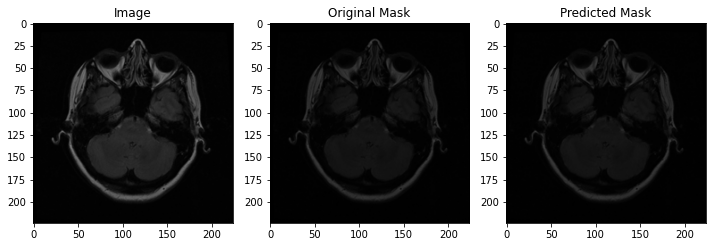

epoch: 2 	step: 1 / 430 	train loss: 0.3666 	train accuracy: 0.9684 	time: 21.5095 s
epoch: 2 	step: 101 / 430 	train loss: 0.2564 	train accuracy: 0.9932 	time: 24.8386 s
epoch: 2 	step: 201 / 430 	train loss: 0.1879 	train accuracy: 0.9947 	time: 21.4414 s
epoch: 2 	step: 301 / 430 	train loss: 0.1741 	train accuracy: 0.9759 	time: 21.4357 s
epoch: 2 	step: 401 / 430 	train loss: 0.1018 	train accuracy: 0.9942 	time: 21.3739 s


  0%|          | 0/32 [00:00<?, ?it/s]

epoch: 2 / 51 	train loss: 0.1992 	valid loss: 0.1140 	train accuracy 0.9897 	valid accuracy 0.9913


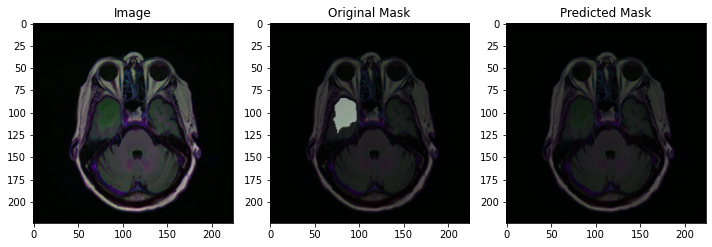

Model saved to: model.pth
epoch: 3 	step: 1 / 430 	train loss: 0.1058 	train accuracy: 0.9929 	time: 21.4097 s
epoch: 3 	step: 101 / 430 	train loss: 0.1143 	train accuracy: 0.9719 	time: 21.4575 s
epoch: 3 	step: 201 / 430 	train loss: 0.0577 	train accuracy: 0.9993 	time: 21.5275 s
epoch: 3 	step: 301 / 430 	train loss: 0.0487 	train accuracy: 0.9984 	time: 21.3377 s
epoch: 3 	step: 401 / 430 	train loss: 0.0708 	train accuracy: 0.9873 	time: 22.1680 s


  0%|          | 0/32 [00:00<?, ?it/s]

epoch: 3 / 51 	train loss: 0.0735 	valid loss: 0.0537 	train accuracy 0.9912 	valid accuracy 0.9908


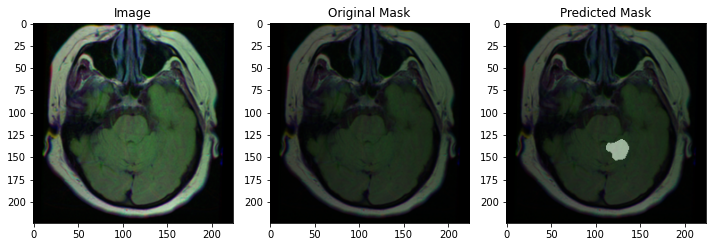

Model saved to: model.pth
epoch: 4 	step: 1 / 430 	train loss: 0.0560 	train accuracy: 0.9913 	time: 21.6628 s
epoch: 4 	step: 101 / 430 	train loss: 0.0474 	train accuracy: 0.9882 	time: 21.4777 s
epoch: 4 	step: 201 / 430 	train loss: 0.0313 	train accuracy: 0.9967 	time: 21.4741 s
epoch: 4 	step: 301 / 430 	train loss: 0.0571 	train accuracy: 0.9784 	time: 21.5180 s
epoch: 4 	step: 401 / 430 	train loss: 0.0610 	train accuracy: 0.9847 	time: 21.4633 s


  0%|          | 0/32 [00:00<?, ?it/s]

epoch: 4 / 51 	train loss: 0.0426 	valid loss: 0.0392 	train accuracy 0.9921 	valid accuracy 0.9920


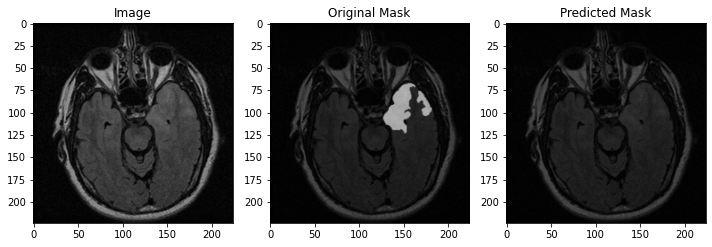

Model saved to: model.pth
epoch: 5 	step: 1 / 430 	train loss: 0.0361 	train accuracy: 0.9932 	time: 21.3610 s
epoch: 5 	step: 101 / 430 	train loss: 0.0591 	train accuracy: 0.9820 	time: 21.3033 s
epoch: 5 	step: 201 / 430 	train loss: 0.0173 	train accuracy: 0.9991 	time: 21.3931 s
epoch: 5 	step: 301 / 430 	train loss: 0.0715 	train accuracy: 0.9783 	time: 21.3788 s
epoch: 5 	step: 401 / 430 	train loss: 0.0266 	train accuracy: 0.9934 	time: 21.4177 s


  0%|          | 0/32 [00:00<?, ?it/s]

epoch: 5 / 51 	train loss: 0.0325 	valid loss: 0.0282 	train accuracy 0.9924 	valid accuracy 0.9928


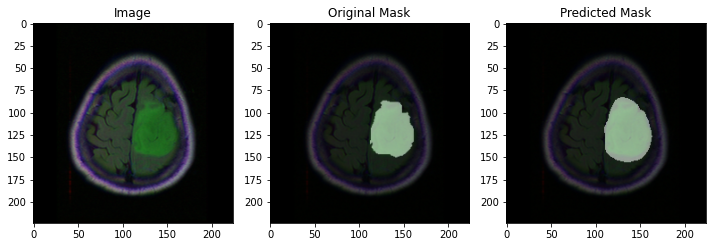

Model saved to: model.pth
epoch: 6 	step: 1 / 430 	train loss: 0.0213 	train accuracy: 0.9943 	time: 21.5561 s
epoch: 6 	step: 101 / 430 	train loss: 0.0159 	train accuracy: 0.9980 	time: 21.3325 s
epoch: 6 	step: 201 / 430 	train loss: 0.0206 	train accuracy: 0.9938 	time: 21.3624 s
epoch: 6 	step: 301 / 430 	train loss: 0.0208 	train accuracy: 0.9955 	time: 22.9043 s
epoch: 6 	step: 401 / 430 	train loss: 0.0242 	train accuracy: 0.9964 	time: 21.4154 s


  0%|          | 0/32 [00:00<?, ?it/s]

epoch: 6 / 51 	train loss: 0.0278 	valid loss: 0.0295 	train accuracy 0.9926 	valid accuracy 0.9918


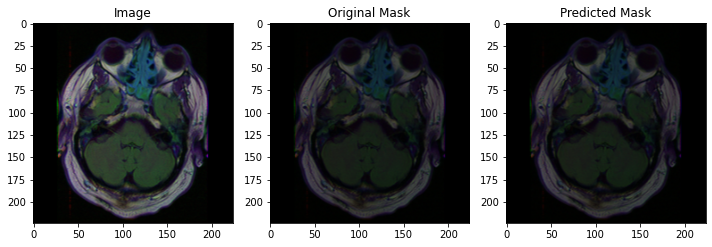

INFO: Early stopping counter 1 of 8
epoch: 7 	step: 1 / 430 	train loss: 0.0544 	train accuracy: 0.9832 	time: 21.6341 s
epoch: 7 	step: 101 / 430 	train loss: 0.0166 	train accuracy: 0.9963 	time: 21.4139 s
epoch: 7 	step: 201 / 430 	train loss: 0.0148 	train accuracy: 0.9964 	time: 21.3339 s
epoch: 7 	step: 301 / 430 	train loss: 0.0125 	train accuracy: 0.9972 	time: 21.4731 s
epoch: 7 	step: 401 / 430 	train loss: 0.0913 	train accuracy: 0.9767 	time: 21.4159 s


  0%|          | 0/32 [00:00<?, ?it/s]

epoch: 7 / 51 	train loss: 0.0256 	valid loss: 0.0253 	train accuracy 0.9926 	valid accuracy 0.9927


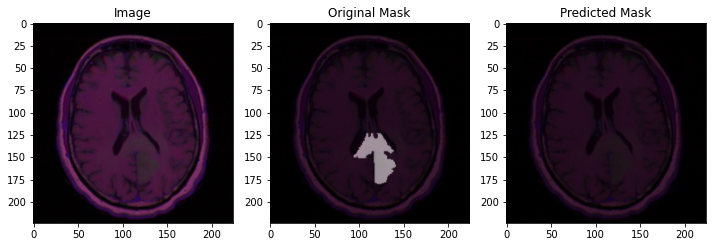

Model saved to: model.pth
epoch: 8 	step: 1 / 430 	train loss: 0.0371 	train accuracy: 0.9875 	time: 21.9420 s
epoch: 8 	step: 101 / 430 	train loss: 0.0495 	train accuracy: 0.9857 	time: 22.3155 s
epoch: 8 	step: 201 / 430 	train loss: 0.0174 	train accuracy: 0.9936 	time: 21.5043 s
epoch: 8 	step: 301 / 430 	train loss: 0.0365 	train accuracy: 0.9873 	time: 21.3184 s
epoch: 8 	step: 401 / 430 	train loss: 0.0149 	train accuracy: 0.9947 	time: 21.3424 s


  0%|          | 0/32 [00:00<?, ?it/s]

epoch: 8 / 51 	train loss: 0.0250 	valid loss: 0.0258 	train accuracy 0.9925 	valid accuracy 0.9924


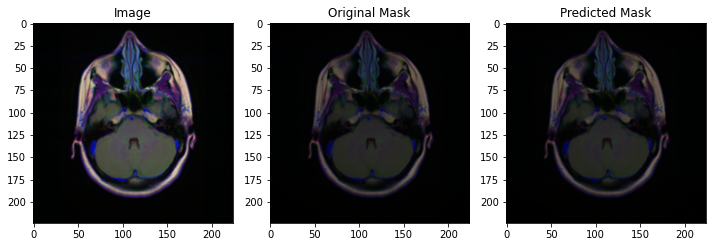

INFO: Early stopping counter 1 of 8
epoch: 9 	step: 1 / 430 	train loss: 0.0350 	train accuracy: 0.9868 	time: 21.4170 s
epoch: 9 	step: 101 / 430 	train loss: 0.0138 	train accuracy: 0.9955 	time: 21.3726 s
epoch: 9 	step: 201 / 430 	train loss: 0.0246 	train accuracy: 0.9911 	time: 21.4432 s
epoch: 9 	step: 301 / 430 	train loss: 0.0235 	train accuracy: 0.9908 	time: 21.4249 s
epoch: 9 	step: 401 / 430 	train loss: 0.0151 	train accuracy: 0.9941 	time: 21.4611 s


  0%|          | 0/32 [00:00<?, ?it/s]

epoch: 9 / 51 	train loss: 0.0236 	valid loss: 0.0187 	train accuracy 0.9926 	valid accuracy 0.9940


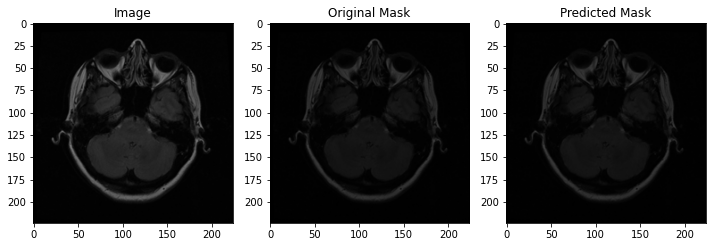

Model saved to: model.pth
epoch: 10 	step: 1 / 430 	train loss: 0.0132 	train accuracy: 0.9969 	time: 21.4891 s
epoch: 10 	step: 101 / 430 	train loss: 0.0449 	train accuracy: 0.9876 	time: 21.4293 s
epoch: 10 	step: 201 / 430 	train loss: 0.0145 	train accuracy: 0.9939 	time: 21.4978 s
epoch: 10 	step: 301 / 430 	train loss: 0.0175 	train accuracy: 0.9921 	time: 21.4497 s
epoch: 10 	step: 401 / 430 	train loss: 0.0180 	train accuracy: 0.9939 	time: 21.3885 s


  0%|          | 0/32 [00:00<?, ?it/s]

epoch: 10 / 51 	train loss: 0.0220 	valid loss: 0.0168 	train accuracy 0.9929 	valid accuracy 0.9939


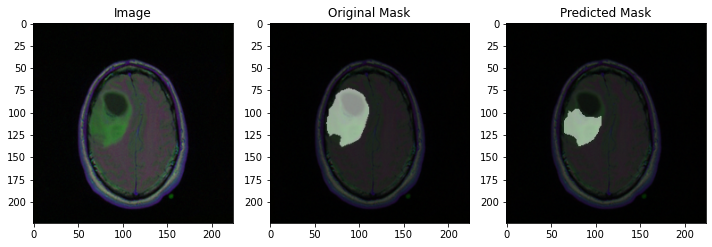

Model saved to: model.pth
epoch: 11 	step: 1 / 430 	train loss: 0.0107 	train accuracy: 0.9958 	time: 21.4154 s
epoch: 11 	step: 101 / 430 	train loss: 0.0205 	train accuracy: 0.9944 	time: 21.4226 s
epoch: 11 	step: 201 / 430 	train loss: 0.0153 	train accuracy: 0.9946 	time: 21.4785 s
epoch: 11 	step: 301 / 430 	train loss: 0.0154 	train accuracy: 0.9935 	time: 22.4883 s
epoch: 11 	step: 401 / 430 	train loss: 0.0107 	train accuracy: 0.9965 	time: 21.4184 s


  0%|          | 0/32 [00:00<?, ?it/s]

epoch: 11 / 51 	train loss: 0.0203 	valid loss: 0.0173 	train accuracy 0.9930 	valid accuracy 0.9937


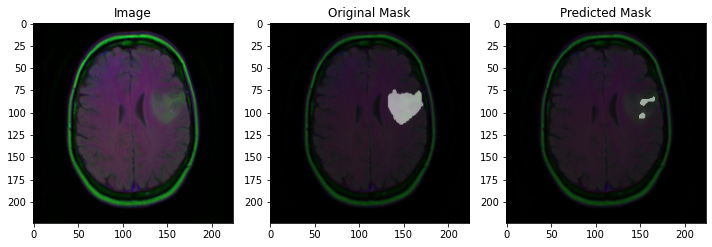

INFO: Early stopping counter 1 of 8
epoch: 12 	step: 1 / 430 	train loss: 0.0143 	train accuracy: 0.9955 	time: 21.3629 s
epoch: 12 	step: 101 / 430 	train loss: 0.0273 	train accuracy: 0.9919 	time: 21.4044 s
epoch: 12 	step: 201 / 430 	train loss: 0.0117 	train accuracy: 0.9967 	time: 21.4720 s
epoch: 12 	step: 301 / 430 	train loss: 0.0079 	train accuracy: 0.9974 	time: 21.3843 s
epoch: 12 	step: 401 / 430 	train loss: 0.0164 	train accuracy: 0.9935 	time: 21.3546 s


  0%|          | 0/32 [00:00<?, ?it/s]

epoch: 12 / 51 	train loss: 0.0192 	valid loss: 0.0168 	train accuracy 0.9932 	valid accuracy 0.9936


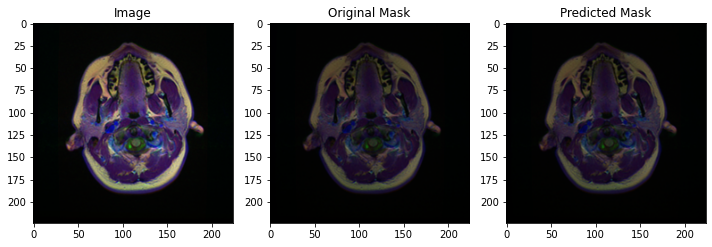

Model saved to: model.pth
epoch: 13 	step: 1 / 430 	train loss: 0.0241 	train accuracy: 0.9936 	time: 21.5520 s
epoch: 13 	step: 101 / 430 	train loss: 0.0121 	train accuracy: 0.9963 	time: 21.4144 s
epoch: 13 	step: 201 / 430 	train loss: 0.0183 	train accuracy: 0.9915 	time: 21.3714 s
epoch: 13 	step: 301 / 430 	train loss: 0.0103 	train accuracy: 0.9946 	time: 21.4706 s
epoch: 13 	step: 401 / 430 	train loss: 0.0106 	train accuracy: 0.9947 	time: 21.2537 s


  0%|          | 0/32 [00:00<?, ?it/s]

epoch: 13 / 51 	train loss: 0.0175 	valid loss: 0.0185 	train accuracy 0.9935 	valid accuracy 0.9932


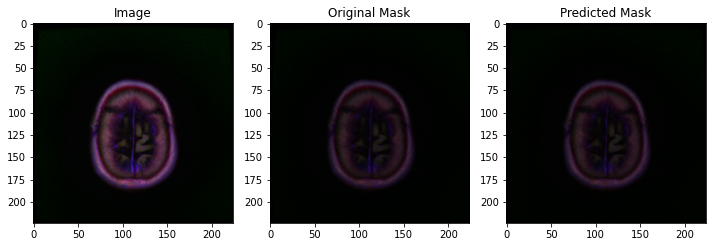

INFO: Early stopping counter 1 of 8
epoch: 14 	step: 1 / 430 	train loss: 0.0301 	train accuracy: 0.9844 	time: 21.4014 s
epoch: 14 	step: 101 / 430 	train loss: 0.0206 	train accuracy: 0.9906 	time: 21.3447 s
epoch: 14 	step: 201 / 430 	train loss: 0.0054 	train accuracy: 0.9986 	time: 21.4295 s
epoch: 14 	step: 301 / 430 	train loss: 0.0140 	train accuracy: 0.9934 	time: 21.4508 s
epoch: 14 	step: 401 / 430 	train loss: 0.0288 	train accuracy: 0.9877 	time: 21.3669 s


  0%|          | 0/32 [00:00<?, ?it/s]

epoch: 14 / 51 	train loss: 0.0168 	valid loss: 0.0152 	train accuracy 0.9938 	valid accuracy 0.9938


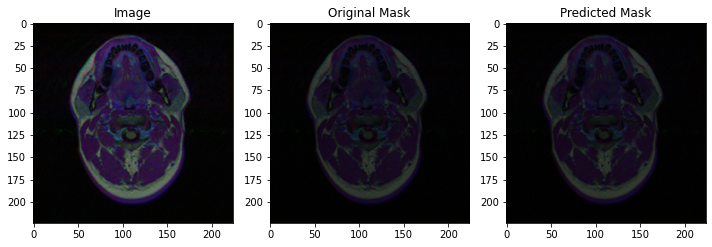

Model saved to: model.pth
epoch: 15 	step: 1 / 430 	train loss: 0.0140 	train accuracy: 0.9949 	time: 21.5265 s
epoch: 15 	step: 101 / 430 	train loss: 0.0118 	train accuracy: 0.9963 	time: 22.3437 s
epoch: 15 	step: 201 / 430 	train loss: 0.0126 	train accuracy: 0.9940 	time: 21.3686 s
epoch: 15 	step: 301 / 430 	train loss: 0.0223 	train accuracy: 0.9899 	time: 21.4598 s
epoch: 15 	step: 401 / 430 	train loss: 0.0170 	train accuracy: 0.9929 	time: 21.3764 s


  0%|          | 0/32 [00:00<?, ?it/s]

epoch: 15 / 51 	train loss: 0.0162 	valid loss: 0.0115 	train accuracy 0.9938 	valid accuracy 0.9953


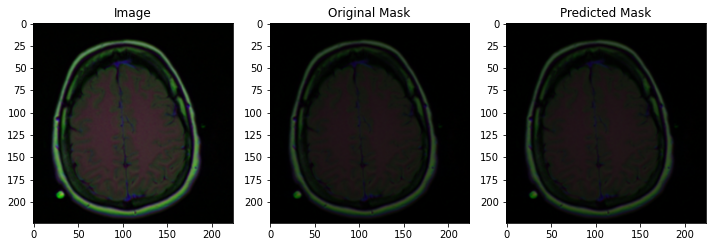

Model saved to: model.pth
epoch: 16 	step: 1 / 430 	train loss: 0.0092 	train accuracy: 0.9962 	time: 21.4414 s
epoch: 16 	step: 101 / 430 	train loss: 0.0177 	train accuracy: 0.9932 	time: 21.4787 s
epoch: 16 	step: 201 / 430 	train loss: 0.0132 	train accuracy: 0.9954 	time: 21.3418 s
epoch: 16 	step: 301 / 430 	train loss: 0.0020 	train accuracy: 1.0000 	time: 22.4662 s
epoch: 16 	step: 401 / 430 	train loss: 0.0159 	train accuracy: 0.9942 	time: 21.3611 s


  0%|          | 0/32 [00:00<?, ?it/s]

epoch: 16 / 51 	train loss: 0.0152 	valid loss: 0.0112 	train accuracy 0.9942 	valid accuracy 0.9949


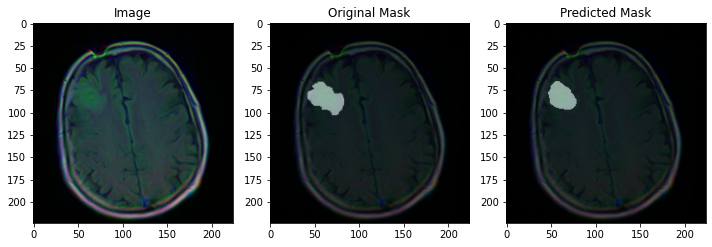

Model saved to: model.pth
epoch: 17 	step: 1 / 430 	train loss: 0.0179 	train accuracy: 0.9917 	time: 21.4061 s
epoch: 17 	step: 101 / 430 	train loss: 0.0284 	train accuracy: 0.9877 	time: 21.3520 s
epoch: 17 	step: 201 / 430 	train loss: 0.0183 	train accuracy: 0.9915 	time: 21.4418 s
epoch: 17 	step: 301 / 430 	train loss: 0.0059 	train accuracy: 0.9978 	time: 21.4384 s
epoch: 17 	step: 401 / 430 	train loss: 0.0101 	train accuracy: 0.9955 	time: 21.4187 s


  0%|          | 0/32 [00:00<?, ?it/s]

epoch: 17 / 51 	train loss: 0.0144 	valid loss: 0.0100 	train accuracy 0.9943 	valid accuracy 0.9955


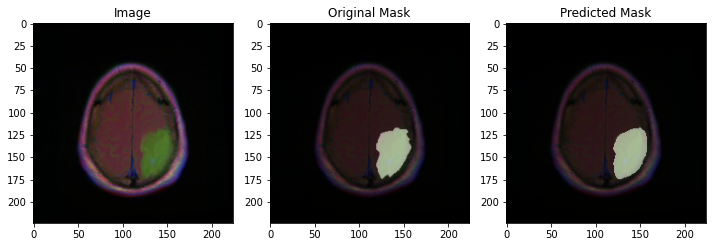

Model saved to: model.pth
epoch: 18 	step: 1 / 430 	train loss: 0.0153 	train accuracy: 0.9928 	time: 21.4430 s
epoch: 18 	step: 101 / 430 	train loss: 0.0083 	train accuracy: 0.9967 	time: 21.4979 s
epoch: 18 	step: 201 / 430 	train loss: 0.0198 	train accuracy: 0.9907 	time: 21.2983 s
epoch: 18 	step: 301 / 430 	train loss: 0.0057 	train accuracy: 0.9974 	time: 22.2413 s
epoch: 18 	step: 401 / 430 	train loss: 0.0015 	train accuracy: 1.0000 	time: 21.4511 s


  0%|          | 0/32 [00:00<?, ?it/s]

epoch: 18 / 51 	train loss: 0.0130 	valid loss: 0.0126 	train accuracy 0.9947 	valid accuracy 0.9948


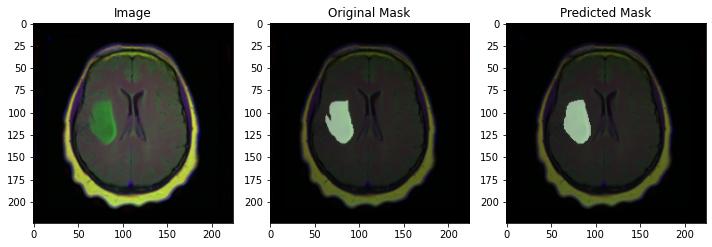

INFO: Early stopping counter 1 of 8
epoch: 19 	step: 1 / 430 	train loss: 0.0097 	train accuracy: 0.9956 	time: 21.4970 s
epoch: 19 	step: 101 / 430 	train loss: 0.0047 	train accuracy: 0.9972 	time: 21.4784 s
epoch: 19 	step: 201 / 430 	train loss: 0.0089 	train accuracy: 0.9969 	time: 22.9626 s
epoch: 19 	step: 301 / 430 	train loss: 0.0119 	train accuracy: 0.9950 	time: 21.5917 s
epoch: 19 	step: 401 / 430 	train loss: 0.0061 	train accuracy: 0.9980 	time: 21.3901 s


  0%|          | 0/32 [00:00<?, ?it/s]

epoch: 19 / 51 	train loss: 0.0137 	valid loss: 0.0121 	train accuracy 0.9945 	valid accuracy 0.9949


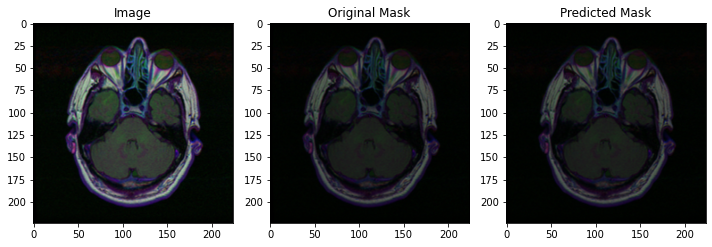

INFO: Early stopping counter 2 of 8
epoch: 20 	step: 1 / 430 	train loss: 0.0100 	train accuracy: 0.9959 	time: 21.4007 s
epoch: 20 	step: 101 / 430 	train loss: 0.0121 	train accuracy: 0.9941 	time: 21.4334 s
epoch: 20 	step: 201 / 430 	train loss: 0.0056 	train accuracy: 0.9978 	time: 21.3737 s
epoch: 20 	step: 301 / 430 	train loss: 0.0104 	train accuracy: 0.9946 	time: 21.3789 s
epoch: 20 	step: 401 / 430 	train loss: 0.0057 	train accuracy: 0.9972 	time: 21.5329 s


  0%|          | 0/32 [00:00<?, ?it/s]

epoch: 20 / 51 	train loss: 0.0117 	valid loss: 0.0095 	train accuracy 0.9950 	valid accuracy 0.9957


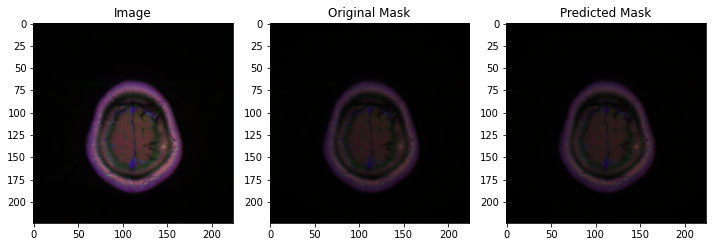

Model saved to: model.pth
epoch: 21 	step: 1 / 430 	train loss: 0.0121 	train accuracy: 0.9934 	time: 21.5395 s
epoch: 21 	step: 101 / 430 	train loss: 0.0037 	train accuracy: 0.9986 	time: 21.5470 s
epoch: 21 	step: 201 / 430 	train loss: 0.0317 	train accuracy: 0.9880 	time: 21.4853 s
epoch: 21 	step: 301 / 430 	train loss: 0.0139 	train accuracy: 0.9941 	time: 21.3634 s
epoch: 21 	step: 401 / 430 	train loss: 0.0049 	train accuracy: 0.9974 	time: 21.4137 s


  0%|          | 0/32 [00:00<?, ?it/s]

epoch: 21 / 51 	train loss: 0.0130 	valid loss: 0.0094 	train accuracy 0.9947 	valid accuracy 0.9960


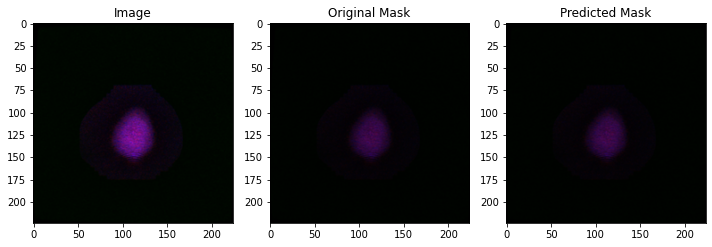

Model saved to: model.pth
epoch: 22 	step: 1 / 430 	train loss: 0.0176 	train accuracy: 0.9902 	time: 21.4459 s
epoch: 22 	step: 101 / 430 	train loss: 0.0099 	train accuracy: 0.9951 	time: 21.6752 s
epoch: 22 	step: 201 / 430 	train loss: 0.0064 	train accuracy: 0.9976 	time: 21.4136 s
epoch: 22 	step: 301 / 430 	train loss: 0.0040 	train accuracy: 0.9992 	time: 21.4803 s
epoch: 22 	step: 401 / 430 	train loss: 0.0110 	train accuracy: 0.9943 	time: 21.4953 s


  0%|          | 0/32 [00:00<?, ?it/s]

epoch: 22 / 51 	train loss: 0.0124 	valid loss: 0.0096 	train accuracy 0.9949 	valid accuracy 0.9958


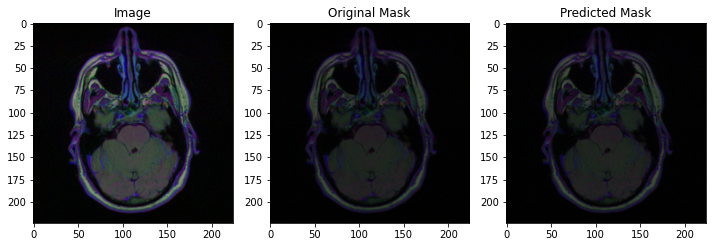

INFO: Early stopping counter 1 of 8
epoch: 23 	step: 1 / 430 	train loss: 0.0029 	train accuracy: 0.9988 	time: 21.4988 s
epoch: 23 	step: 101 / 430 	train loss: 0.0124 	train accuracy: 0.9956 	time: 21.5981 s
epoch: 23 	step: 201 / 430 	train loss: 0.0179 	train accuracy: 0.9902 	time: 21.5135 s
epoch: 23 	step: 301 / 430 	train loss: 0.0089 	train accuracy: 0.9961 	time: 21.3618 s
epoch: 23 	step: 401 / 430 	train loss: 0.0023 	train accuracy: 0.9990 	time: 21.4528 s


  0%|          | 0/32 [00:00<?, ?it/s]

epoch: 23 / 51 	train loss: 0.0109 	valid loss: 0.0120 	train accuracy 0.9954 	valid accuracy 0.9949


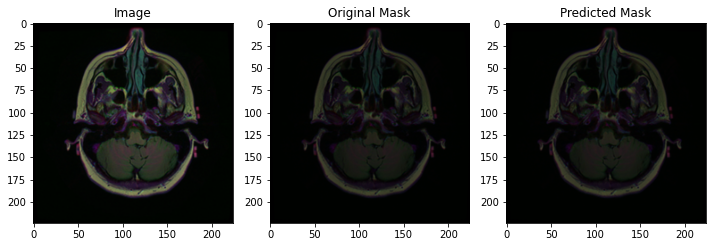

INFO: Early stopping counter 2 of 8
epoch: 24 	step: 1 / 430 	train loss: 0.0108 	train accuracy: 0.9951 	time: 22.6296 s
epoch: 24 	step: 101 / 430 	train loss: 0.0229 	train accuracy: 0.9889 	time: 21.5649 s
epoch: 24 	step: 201 / 430 	train loss: 0.0128 	train accuracy: 0.9951 	time: 21.4795 s
epoch: 24 	step: 301 / 430 	train loss: 0.0078 	train accuracy: 0.9965 	time: 21.3388 s
epoch: 24 	step: 401 / 430 	train loss: 0.0087 	train accuracy: 0.9961 	time: 21.4149 s


  0%|          | 0/32 [00:00<?, ?it/s]

epoch: 24 / 51 	train loss: 0.0120 	valid loss: 0.0097 	train accuracy 0.9950 	valid accuracy 0.9955


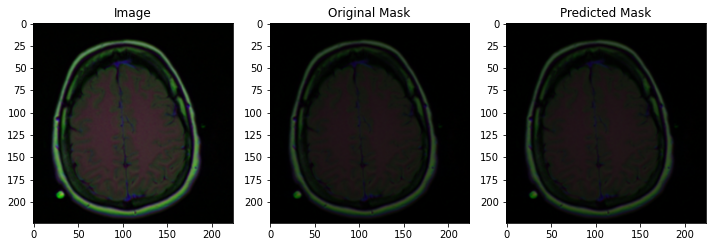

INFO: Early stopping counter 3 of 8
epoch: 25 	step: 1 / 430 	train loss: 0.0052 	train accuracy: 0.9973 	time: 21.3583 s
epoch: 25 	step: 101 / 430 	train loss: 0.0172 	train accuracy: 0.9919 	time: 21.4666 s
epoch: 25 	step: 201 / 430 	train loss: 0.0098 	train accuracy: 0.9968 	time: 21.3580 s
epoch: 25 	step: 301 / 430 	train loss: 0.0104 	train accuracy: 0.9943 	time: 21.4100 s
epoch: 25 	step: 401 / 430 	train loss: 0.0168 	train accuracy: 0.9921 	time: 21.3721 s


  0%|          | 0/32 [00:00<?, ?it/s]

epoch: 25 / 51 	train loss: 0.0106 	valid loss: 0.0083 	train accuracy 0.9953 	valid accuracy 0.9961


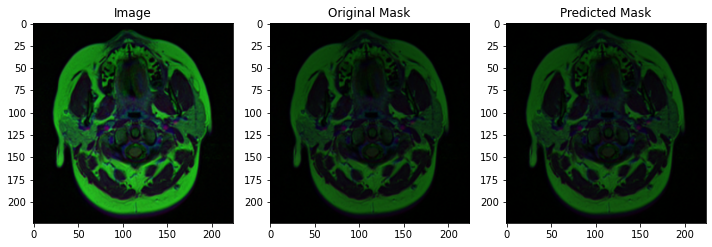

Model saved to: model.pth
epoch: 26 	step: 1 / 430 	train loss: 0.0064 	train accuracy: 0.9971 	time: 21.4772 s
epoch: 26 	step: 101 / 430 	train loss: 0.0071 	train accuracy: 0.9979 	time: 21.6009 s
epoch: 26 	step: 201 / 430 	train loss: 0.0070 	train accuracy: 0.9963 	time: 21.4175 s
epoch: 26 	step: 301 / 430 	train loss: 0.0341 	train accuracy: 0.9843 	time: 21.4320 s
epoch: 26 	step: 401 / 430 	train loss: 0.0077 	train accuracy: 0.9969 	time: 21.6378 s


  0%|          | 0/32 [00:00<?, ?it/s]

epoch: 26 / 51 	train loss: 0.0132 	valid loss: 0.0081 	train accuracy 0.9947 	valid accuracy 0.9963


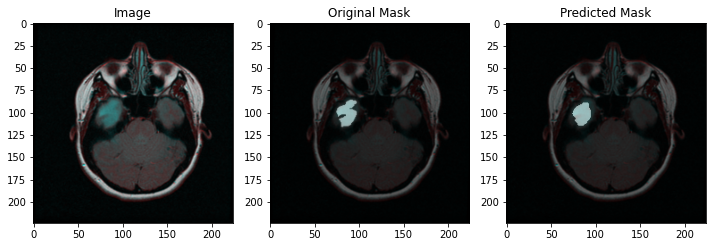

Model saved to: model.pth
epoch: 27 	step: 1 / 430 	train loss: 0.0209 	train accuracy: 0.9883 	time: 21.3619 s
epoch: 27 	step: 101 / 430 	train loss: 0.0097 	train accuracy: 0.9964 	time: 21.4531 s
epoch: 27 	step: 201 / 430 	train loss: 0.0048 	train accuracy: 0.9985 	time: 21.4884 s
epoch: 27 	step: 301 / 430 	train loss: 0.0145 	train accuracy: 0.9929 	time: 21.4140 s
epoch: 27 	step: 401 / 430 	train loss: 0.0088 	train accuracy: 0.9966 	time: 21.4494 s


  0%|          | 0/32 [00:00<?, ?it/s]

epoch: 27 / 51 	train loss: 0.0112 	valid loss: 0.0079 	train accuracy 0.9953 	valid accuracy 0.9963


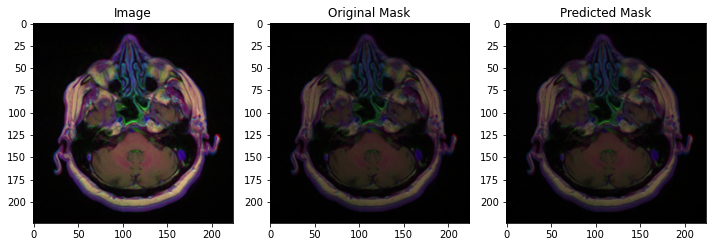

Model saved to: model.pth
epoch: 28 	step: 1 / 430 	train loss: 0.0119 	train accuracy: 0.9941 	time: 21.4713 s
epoch: 28 	step: 101 / 430 	train loss: 0.0398 	train accuracy: 0.9814 	time: 21.4785 s
epoch: 28 	step: 201 / 430 	train loss: 0.0171 	train accuracy: 0.9920 	time: 23.5728 s
epoch: 28 	step: 301 / 430 	train loss: 0.0056 	train accuracy: 0.9982 	time: 21.3091 s
epoch: 28 	step: 401 / 430 	train loss: 0.0089 	train accuracy: 0.9953 	time: 21.3696 s


  0%|          | 0/32 [00:00<?, ?it/s]

epoch: 28 / 51 	train loss: 0.0127 	valid loss: 0.0078 	train accuracy 0.9948 	valid accuracy 0.9964


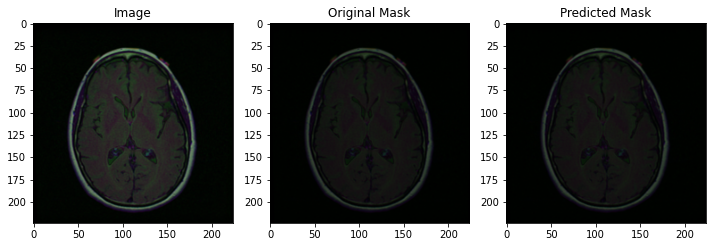

Model saved to: model.pth
epoch: 29 	step: 1 / 430 	train loss: 0.0079 	train accuracy: 0.9969 	time: 21.4808 s
epoch: 29 	step: 101 / 430 	train loss: 0.0043 	train accuracy: 0.9979 	time: 21.3594 s
epoch: 29 	step: 201 / 430 	train loss: 0.0005 	train accuracy: 1.0000 	time: 21.5977 s
epoch: 29 	step: 301 / 430 	train loss: 0.0039 	train accuracy: 0.9984 	time: 22.3135 s
epoch: 29 	step: 401 / 430 	train loss: 0.0086 	train accuracy: 0.9953 	time: 21.5469 s


  0%|          | 0/32 [00:00<?, ?it/s]

epoch: 29 / 51 	train loss: 0.0107 	valid loss: 0.0085 	train accuracy 0.9954 	valid accuracy 0.9962


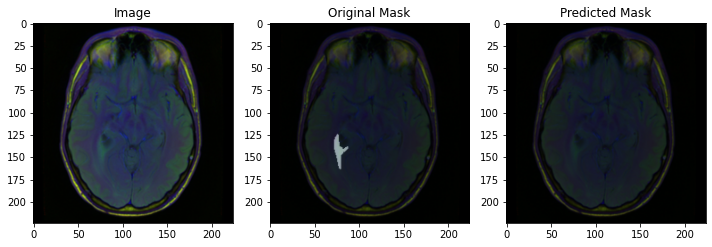

INFO: Early stopping counter 1 of 8
epoch: 30 	step: 1 / 430 	train loss: 0.0063 	train accuracy: 0.9967 	time: 21.4727 s
epoch: 30 	step: 101 / 430 	train loss: 0.0047 	train accuracy: 0.9980 	time: 21.3888 s
epoch: 30 	step: 201 / 430 	train loss: 0.0064 	train accuracy: 0.9971 	time: 21.4488 s
epoch: 30 	step: 301 / 430 	train loss: 0.0183 	train accuracy: 0.9914 	time: 22.5459 s
epoch: 30 	step: 401 / 430 	train loss: 0.0166 	train accuracy: 0.9942 	time: 21.4485 s


  0%|          | 0/32 [00:00<?, ?it/s]

epoch: 30 / 51 	train loss: 0.0100 	valid loss: 0.0185 	train accuracy 0.9955 	valid accuracy 0.9943


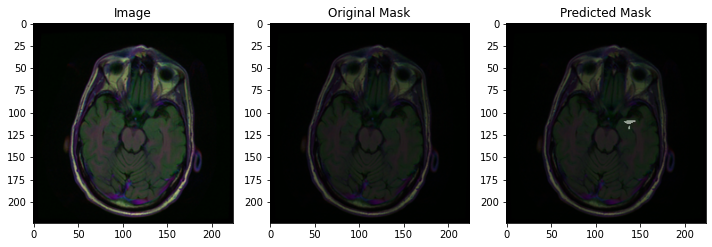

INFO: Early stopping counter 2 of 8
epoch: 31 	step: 1 / 430 	train loss: 0.0412 	train accuracy: 0.9869 	time: 21.5080 s
epoch: 31 	step: 101 / 430 	train loss: 0.0095 	train accuracy: 0.9956 	time: 21.4769 s
epoch: 31 	step: 201 / 430 	train loss: 0.0142 	train accuracy: 0.9940 	time: 21.3589 s
epoch: 31 	step: 301 / 430 	train loss: 0.0100 	train accuracy: 0.9975 	time: 21.4586 s
epoch: 31 	step: 401 / 430 	train loss: 0.0060 	train accuracy: 0.9970 	time: 21.3583 s


  0%|          | 0/32 [00:00<?, ?it/s]

epoch: 31 / 51 	train loss: 0.0122 	valid loss: 0.0092 	train accuracy 0.9949 	valid accuracy 0.9961


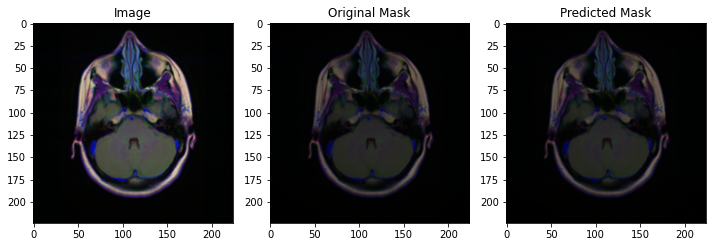

INFO: Early stopping counter 3 of 8
epoch: 32 	step: 1 / 430 	train loss: 0.0151 	train accuracy: 0.9916 	time: 21.5170 s
epoch: 32 	step: 101 / 430 	train loss: 0.0275 	train accuracy: 0.9899 	time: 21.5633 s
epoch: 32 	step: 201 / 430 	train loss: 0.0099 	train accuracy: 0.9954 	time: 21.4598 s
epoch: 32 	step: 301 / 430 	train loss: 0.0042 	train accuracy: 0.9983 	time: 21.5718 s
epoch: 32 	step: 401 / 430 	train loss: 0.0066 	train accuracy: 0.9978 	time: 21.3731 s


  0%|          | 0/32 [00:00<?, ?it/s]

epoch: 32 / 51 	train loss: 0.0096 	valid loss: 0.0073 	train accuracy 0.9958 	valid accuracy 0.9966


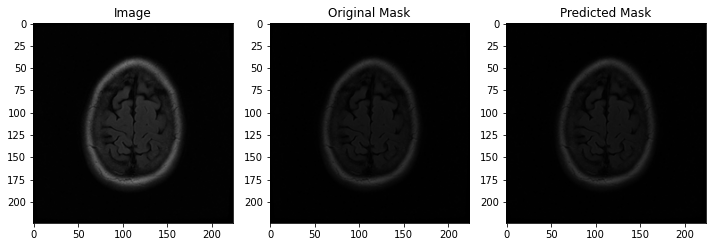

Model saved to: model.pth
epoch: 33 	step: 1 / 430 	train loss: 0.0137 	train accuracy: 0.9929 	time: 21.5168 s
epoch: 33 	step: 101 / 430 	train loss: 0.0177 	train accuracy: 0.9909 	time: 21.3330 s
epoch: 33 	step: 201 / 430 	train loss: 0.0123 	train accuracy: 0.9945 	time: 23.9217 s
epoch: 33 	step: 301 / 430 	train loss: 0.0126 	train accuracy: 0.9934 	time: 22.0695 s
epoch: 33 	step: 401 / 430 	train loss: 0.0065 	train accuracy: 0.9971 	time: 21.3712 s


  0%|          | 0/32 [00:00<?, ?it/s]

epoch: 33 / 51 	train loss: 0.0097 	valid loss: 0.0073 	train accuracy 0.9957 	valid accuracy 0.9966


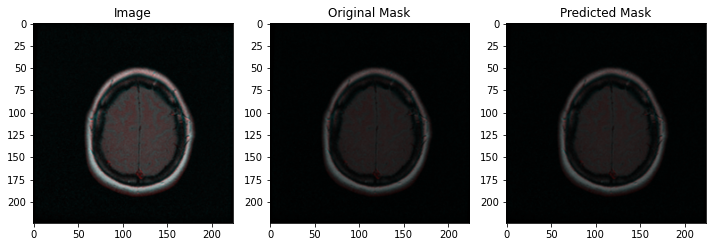

INFO: Early stopping counter 1 of 8
epoch: 34 	step: 1 / 430 	train loss: 0.0033 	train accuracy: 0.9984 	time: 21.3995 s
epoch: 34 	step: 101 / 430 	train loss: 0.0108 	train accuracy: 0.9952 	time: 21.6849 s
epoch: 34 	step: 201 / 430 	train loss: 0.0063 	train accuracy: 0.9974 	time: 21.5596 s
epoch: 34 	step: 301 / 430 	train loss: 0.0071 	train accuracy: 0.9958 	time: 21.5183 s
epoch: 34 	step: 401 / 430 	train loss: 0.0046 	train accuracy: 0.9978 	time: 21.4031 s


  0%|          | 0/32 [00:00<?, ?it/s]

epoch: 34 / 51 	train loss: 0.0093 	valid loss: 0.0074 	train accuracy 0.9958 	valid accuracy 0.9964


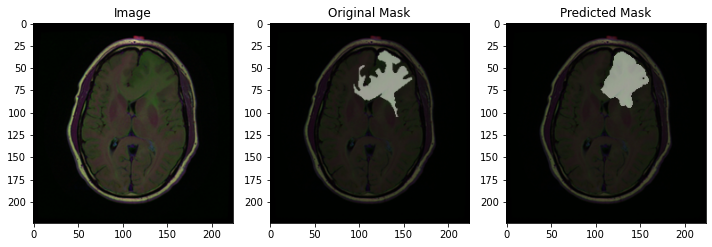

INFO: Early stopping counter 2 of 8
epoch: 35 	step: 1 / 430 	train loss: 0.0045 	train accuracy: 0.9976 	time: 21.4627 s
epoch: 35 	step: 101 / 430 	train loss: 0.0136 	train accuracy: 0.9927 	time: 21.3359 s
epoch: 35 	step: 201 / 430 	train loss: 0.0143 	train accuracy: 0.9940 	time: 21.3770 s
epoch: 35 	step: 301 / 430 	train loss: 0.0083 	train accuracy: 0.9955 	time: 21.8336 s
epoch: 35 	step: 401 / 430 	train loss: 0.0046 	train accuracy: 0.9974 	time: 21.3774 s


  0%|          | 0/32 [00:00<?, ?it/s]

epoch: 35 / 51 	train loss: 0.0100 	valid loss: 0.0085 	train accuracy 0.9955 	valid accuracy 0.9964


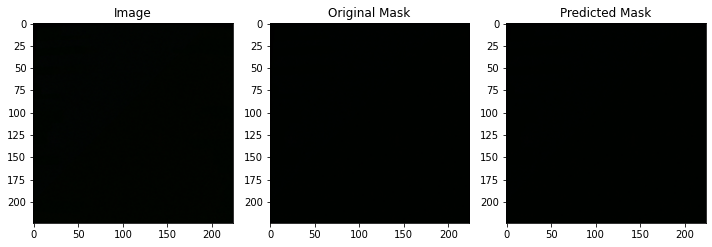

INFO: Early stopping counter 3 of 8
epoch: 36 	step: 1 / 430 	train loss: 0.0028 	train accuracy: 0.9987 	time: 21.5201 s
epoch: 36 	step: 101 / 430 	train loss: 0.0037 	train accuracy: 0.9984 	time: 21.4381 s
epoch: 36 	step: 201 / 430 	train loss: 0.0094 	train accuracy: 0.9954 	time: 21.3655 s
epoch: 36 	step: 301 / 430 	train loss: 0.0074 	train accuracy: 0.9973 	time: 21.4274 s
epoch: 36 	step: 401 / 430 	train loss: 0.0038 	train accuracy: 0.9981 	time: 21.3924 s


  0%|          | 0/32 [00:00<?, ?it/s]

epoch: 36 / 51 	train loss: 0.0094 	valid loss: 0.0110 	train accuracy 0.9958 	valid accuracy 0.9951


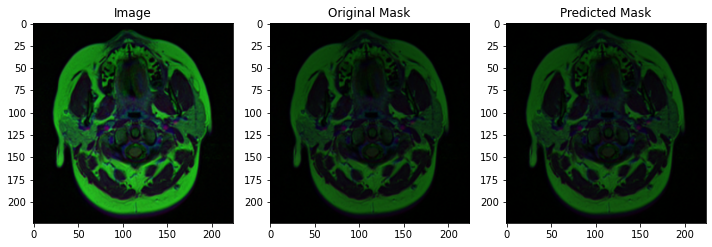

INFO: Early stopping counter 4 of 8
epoch: 37 	step: 1 / 430 	train loss: 0.0271 	train accuracy: 0.9868 	time: 23.2533 s
epoch: 37 	step: 101 / 430 	train loss: 0.0128 	train accuracy: 0.9940 	time: 21.5667 s
epoch: 37 	step: 201 / 430 	train loss: 0.0092 	train accuracy: 0.9943 	time: 21.4623 s
epoch: 37 	step: 301 / 430 	train loss: 0.0092 	train accuracy: 0.9955 	time: 21.3685 s
epoch: 37 	step: 401 / 430 	train loss: 0.0126 	train accuracy: 0.9938 	time: 23.6387 s


  0%|          | 0/32 [00:00<?, ?it/s]

epoch: 37 / 51 	train loss: 0.0090 	valid loss: 0.0073 	train accuracy 0.9959 	valid accuracy 0.9966


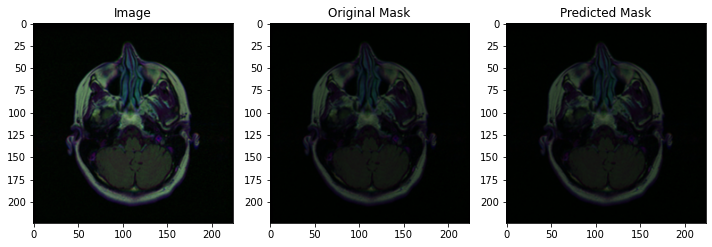

INFO: Early stopping counter 5 of 8
epoch: 38 	step: 1 / 430 	train loss: 0.0093 	train accuracy: 0.9951 	time: 21.4845 s
epoch: 38 	step: 101 / 430 	train loss: 0.0035 	train accuracy: 0.9990 	time: 21.4627 s
epoch: 38 	step: 201 / 430 	train loss: 0.0079 	train accuracy: 0.9967 	time: 21.4045 s
epoch: 38 	step: 301 / 430 	train loss: 0.0109 	train accuracy: 0.9947 	time: 21.4617 s
epoch: 38 	step: 401 / 430 	train loss: 0.0090 	train accuracy: 0.9947 	time: 21.4943 s


  0%|          | 0/32 [00:00<?, ?it/s]

epoch: 38 / 51 	train loss: 0.0093 	valid loss: 0.0072 	train accuracy 0.9959 	valid accuracy 0.9966


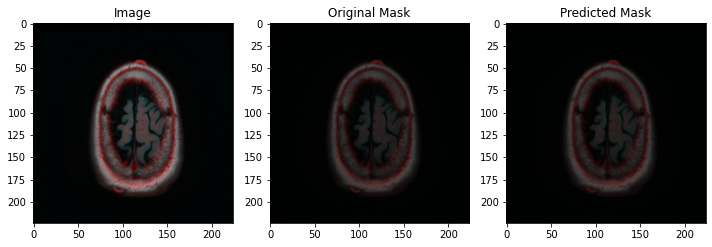

Model saved to: model.pth
epoch: 39 	step: 1 / 430 	train loss: 0.0092 	train accuracy: 0.9947 	time: 21.3705 s
epoch: 39 	step: 101 / 430 	train loss: 0.0055 	train accuracy: 0.9974 	time: 21.4995 s
epoch: 39 	step: 201 / 430 	train loss: 0.0144 	train accuracy: 0.9957 	time: 21.3876 s
epoch: 39 	step: 301 / 430 	train loss: 0.0032 	train accuracy: 0.9987 	time: 21.4176 s
epoch: 39 	step: 401 / 430 	train loss: 0.0041 	train accuracy: 0.9986 	time: 21.2654 s


  0%|          | 0/32 [00:00<?, ?it/s]

epoch: 39 / 51 	train loss: 0.0092 	valid loss: 0.0075 	train accuracy 0.9958 	valid accuracy 0.9966


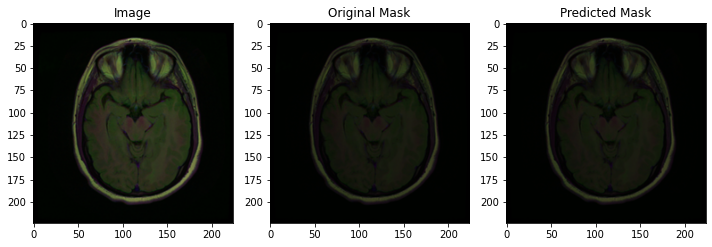

INFO: Early stopping counter 1 of 8
epoch: 40 	step: 1 / 430 	train loss: 0.0217 	train accuracy: 0.9875 	time: 21.4903 s
epoch: 40 	step: 101 / 430 	train loss: 0.0046 	train accuracy: 0.9979 	time: 21.6439 s
epoch: 40 	step: 201 / 430 	train loss: 0.0042 	train accuracy: 0.9986 	time: 21.3297 s
epoch: 40 	step: 301 / 430 	train loss: 0.0092 	train accuracy: 0.9964 	time: 21.4293 s
epoch: 40 	step: 401 / 430 	train loss: 0.0052 	train accuracy: 0.9971 	time: 21.4320 s


  0%|          | 0/32 [00:00<?, ?it/s]

epoch: 40 / 51 	train loss: 0.0107 	valid loss: 0.0071 	train accuracy 0.9954 	valid accuracy 0.9967


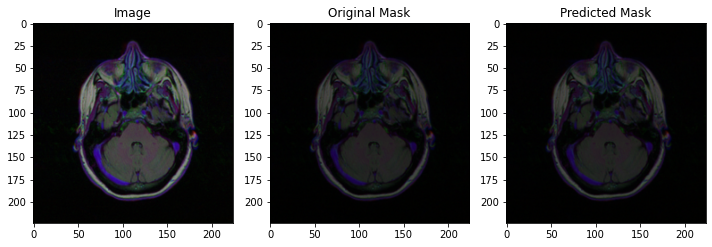

Model saved to: model.pth
epoch: 41 	step: 1 / 430 	train loss: 0.0041 	train accuracy: 0.9978 	time: 21.4392 s
epoch: 41 	step: 101 / 430 	train loss: 0.0207 	train accuracy: 0.9908 	time: 24.4612 s
epoch: 41 	step: 201 / 430 	train loss: 0.0026 	train accuracy: 0.9988 	time: 21.4765 s
epoch: 41 	step: 301 / 430 	train loss: 0.0085 	train accuracy: 0.9959 	time: 21.4325 s
epoch: 41 	step: 401 / 430 	train loss: 0.0053 	train accuracy: 0.9971 	time: 21.6056 s


  0%|          | 0/32 [00:00<?, ?it/s]

epoch: 41 / 51 	train loss: 0.0090 	valid loss: 0.0129 	train accuracy 0.9958 	valid accuracy 0.9945


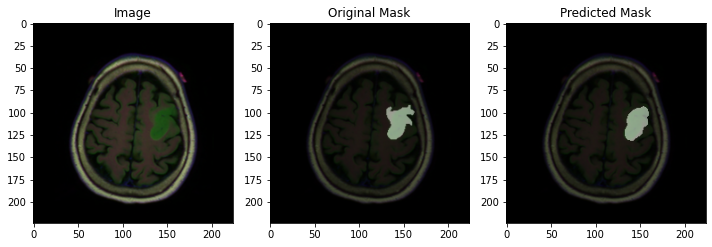

INFO: Early stopping counter 1 of 8
epoch: 42 	step: 1 / 430 	train loss: 0.0091 	train accuracy: 0.9957 	time: 22.2475 s
epoch: 42 	step: 101 / 430 	train loss: 0.0018 	train accuracy: 0.9992 	time: 21.3948 s
epoch: 42 	step: 201 / 430 	train loss: 0.0067 	train accuracy: 0.9963 	time: 21.3858 s
epoch: 42 	step: 301 / 430 	train loss: 0.0212 	train accuracy: 0.9885 	time: 21.6071 s
epoch: 42 	step: 401 / 430 	train loss: 0.0054 	train accuracy: 0.9971 	time: 21.3502 s


  0%|          | 0/32 [00:00<?, ?it/s]

epoch: 42 / 51 	train loss: 0.0097 	valid loss: 0.0071 	train accuracy 0.9956 	valid accuracy 0.9967


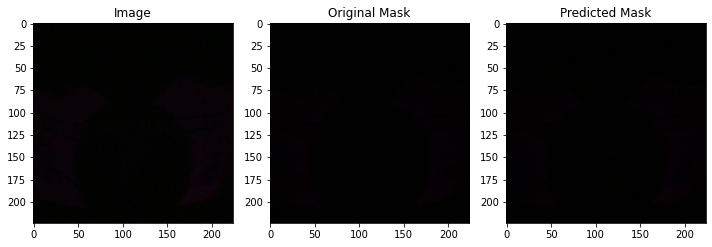

INFO: Early stopping counter 2 of 8
epoch: 43 	step: 1 / 430 	train loss: 0.0039 	train accuracy: 0.9979 	time: 21.3443 s
epoch: 43 	step: 101 / 430 	train loss: 0.0133 	train accuracy: 0.9932 	time: 21.5271 s
epoch: 43 	step: 201 / 430 	train loss: 0.0131 	train accuracy: 0.9924 	time: 21.4896 s
epoch: 43 	step: 301 / 430 	train loss: 0.0044 	train accuracy: 0.9974 	time: 21.4536 s
epoch: 43 	step: 401 / 430 	train loss: 0.0117 	train accuracy: 0.9944 	time: 21.5604 s


  0%|          | 0/32 [00:00<?, ?it/s]

epoch: 43 / 51 	train loss: 0.0096 	valid loss: 0.0073 	train accuracy 0.9956 	valid accuracy 0.9966


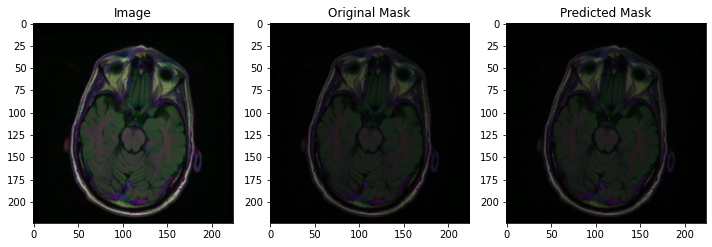

INFO: Early stopping counter 3 of 8
epoch: 44 	step: 1 / 430 	train loss: 0.0030 	train accuracy: 0.9986 	time: 21.4324 s
epoch: 44 	step: 101 / 430 	train loss: 0.0114 	train accuracy: 0.9965 	time: 21.4915 s
epoch: 44 	step: 201 / 430 	train loss: 0.0055 	train accuracy: 0.9971 	time: 21.7509 s
epoch: 44 	step: 301 / 430 	train loss: 0.0070 	train accuracy: 0.9966 	time: 21.3547 s
epoch: 44 	step: 401 / 430 	train loss: 0.0046 	train accuracy: 0.9978 	time: 21.3723 s


  0%|          | 0/32 [00:00<?, ?it/s]

epoch: 44 / 51 	train loss: 0.0090 	valid loss: 0.0070 	train accuracy 0.9959 	valid accuracy 0.9967


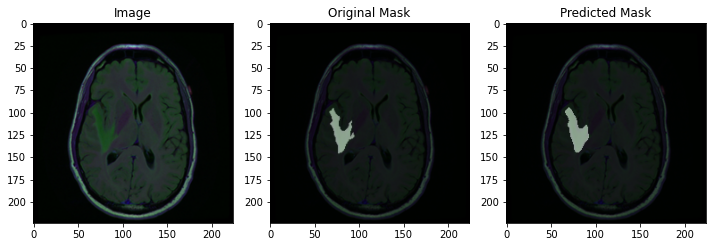

Model saved to: model.pth
epoch: 45 	step: 1 / 430 	train loss: 0.0112 	train accuracy: 0.9965 	time: 21.5738 s
epoch: 45 	step: 101 / 430 	train loss: 0.0140 	train accuracy: 0.9925 	time: 21.4728 s
epoch: 45 	step: 201 / 430 	train loss: 0.0129 	train accuracy: 0.9923 	time: 21.4291 s
epoch: 45 	step: 301 / 430 	train loss: 0.0145 	train accuracy: 0.9931 	time: 21.3510 s
epoch: 45 	step: 401 / 430 	train loss: 0.0107 	train accuracy: 0.9941 	time: 21.4283 s


  0%|          | 0/32 [00:00<?, ?it/s]

epoch: 45 / 51 	train loss: 0.0096 	valid loss: 0.0079 	train accuracy 0.9956 	valid accuracy 0.9964


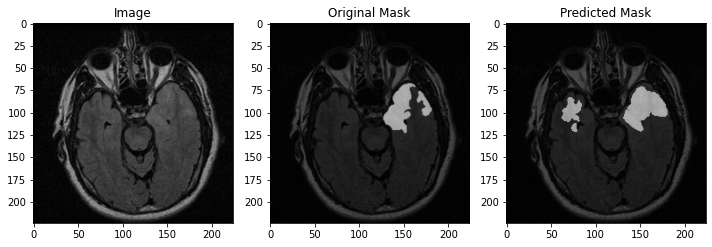

INFO: Early stopping counter 1 of 8
epoch: 46 	step: 1 / 430 	train loss: 0.0148 	train accuracy: 0.9937 	time: 21.4240 s
epoch: 46 	step: 101 / 430 	train loss: 0.0005 	train accuracy: 1.0000 	time: 21.4484 s
epoch: 46 	step: 201 / 430 	train loss: 0.0100 	train accuracy: 0.9940 	time: 21.5486 s
epoch: 46 	step: 301 / 430 	train loss: 0.0060 	train accuracy: 0.9968 	time: 21.2395 s
epoch: 46 	step: 401 / 430 	train loss: 0.0289 	train accuracy: 0.9858 	time: 21.4512 s


  0%|          | 0/32 [00:00<?, ?it/s]

epoch: 46 / 51 	train loss: 0.0089 	valid loss: 0.0082 	train accuracy 0.9958 	valid accuracy 0.9961


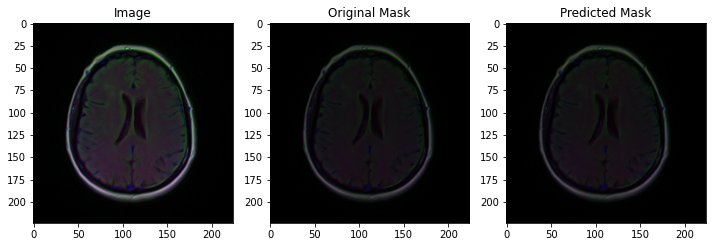

INFO: Early stopping counter 2 of 8
epoch: 47 	step: 1 / 430 	train loss: 0.0170 	train accuracy: 0.9926 	time: 23.2829 s
epoch: 47 	step: 101 / 430 	train loss: 0.0131 	train accuracy: 0.9939 	time: 21.4307 s
epoch: 47 	step: 201 / 430 	train loss: 0.0014 	train accuracy: 0.9994 	time: 21.5165 s
epoch: 47 	step: 301 / 430 	train loss: 0.0114 	train accuracy: 0.9941 	time: 22.2998 s
epoch: 47 	step: 401 / 430 	train loss: 0.0186 	train accuracy: 0.9903 	time: 21.4597 s


  0%|          | 0/32 [00:00<?, ?it/s]

epoch: 47 / 51 	train loss: 0.0086 	valid loss: 0.0066 	train accuracy 0.9960 	valid accuracy 0.9969


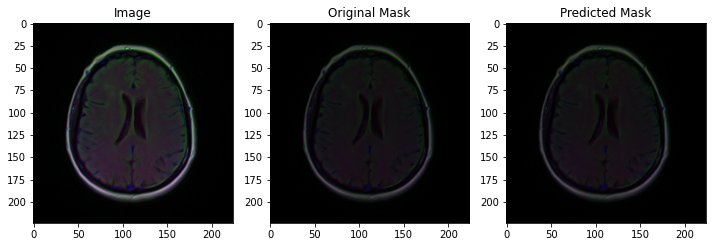

Model saved to: model.pth
epoch: 48 	step: 1 / 430 	train loss: 0.0156 	train accuracy: 0.9921 	time: 21.4007 s
epoch: 48 	step: 101 / 430 	train loss: 0.0139 	train accuracy: 0.9932 	time: 21.4080 s
epoch: 48 	step: 201 / 430 	train loss: 0.0089 	train accuracy: 0.9953 	time: 21.3979 s
epoch: 48 	step: 301 / 430 	train loss: 0.0131 	train accuracy: 0.9935 	time: 21.4705 s
epoch: 48 	step: 401 / 430 	train loss: 0.0246 	train accuracy: 0.9899 	time: 21.4998 s


  0%|          | 0/32 [00:00<?, ?it/s]

epoch: 48 / 51 	train loss: 0.0096 	valid loss: 0.0073 	train accuracy 0.9957 	valid accuracy 0.9966


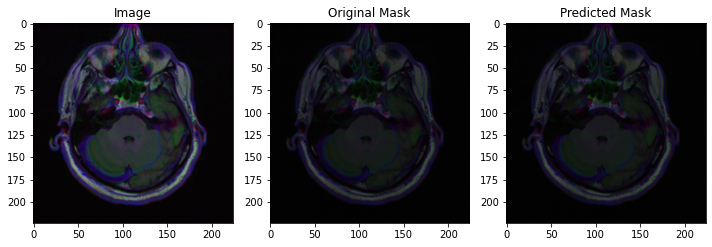

INFO: Early stopping counter 1 of 8
epoch: 49 	step: 1 / 430 	train loss: 0.0036 	train accuracy: 0.9982 	time: 21.4843 s
epoch: 49 	step: 101 / 430 	train loss: 0.0022 	train accuracy: 0.9990 	time: 21.4409 s
epoch: 49 	step: 201 / 430 	train loss: 0.0048 	train accuracy: 0.9984 	time: 21.4547 s
epoch: 49 	step: 301 / 430 	train loss: 0.0077 	train accuracy: 0.9959 	time: 21.3397 s
epoch: 49 	step: 401 / 430 	train loss: 0.0070 	train accuracy: 0.9964 	time: 21.3667 s


  0%|          | 0/32 [00:00<?, ?it/s]

epoch: 49 / 51 	train loss: 0.0088 	valid loss: 0.0073 	train accuracy 0.9959 	valid accuracy 0.9966


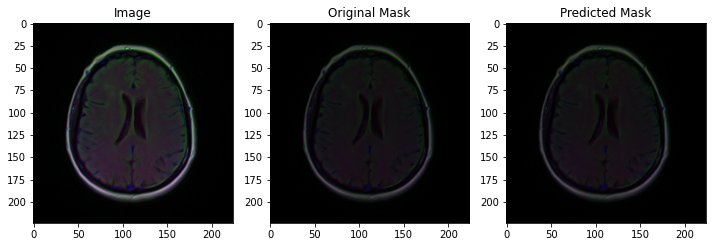

INFO: Early stopping counter 2 of 8
epoch: 50 	step: 1 / 430 	train loss: 0.0102 	train accuracy: 0.9952 	time: 21.5353 s
epoch: 50 	step: 101 / 430 	train loss: 0.0035 	train accuracy: 0.9994 	time: 22.4832 s
epoch: 50 	step: 201 / 430 	train loss: 0.0262 	train accuracy: 0.9905 	time: 21.4617 s
epoch: 50 	step: 301 / 430 	train loss: 0.0058 	train accuracy: 0.9972 	time: 21.3531 s
epoch: 50 	step: 401 / 430 	train loss: 0.0078 	train accuracy: 0.9956 	time: 21.3255 s


  0%|          | 0/32 [00:00<?, ?it/s]

epoch: 50 / 51 	train loss: 0.0084 	valid loss: 0.0067 	train accuracy 0.9960 	valid accuracy 0.9968


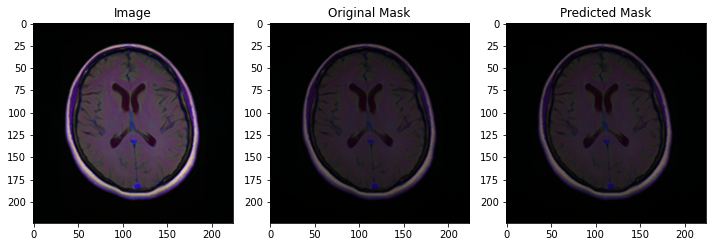

INFO: Early stopping counter 3 of 8


In [30]:
import time

for epoch in range(1, EPOCHS+1):

    train_loss, train_accs = [], []
    for step, batch in enumerate(train_dl, 1):
        time_1 = time.time()
        
        loss, accuracy = train_one_batch(batch, model, optimizer, criterion)

        train_loss.append(loss)
        train_accs.append(accuracy)
        
        if step % print_feq == 0:
            print('epoch:', epoch, 
                  '\tstep:', step, '/', len(train_dl),
                  '\ttrain loss:', '{:.4f}'.format(loss),
                  '\ttrain accuracy:','{:.4f}'.format(accuracy),
                  '\ttime:', '{:.4f}'.format((time.time()-time_1)*print_feq), 's')
    
    valid_loss, valid_accs = [], []
    for step, batch in enumerate(tqdm(valid_dl)):
        loss, accuracy = validate_one_batch(batch, model, criterion)
        
        valid_loss.append(loss)
        valid_accs.append(accuracy)
        
    print('epoch:', epoch, '/', EPOCHS,
            '\ttrain loss:', '{:.4f}'.format(np.mean(train_loss)),
            '\tvalid loss:', '{:.4f}'.format(np.mean(valid_loss)),
            '\ttrain accuracy', '{:.4f}'.format(np.mean(train_accs)),
            '\tvalid accuracy', '{:.4f}'.format(np.mean(valid_accs)))
    
    test_plot(model)
    
    stopper(np.mean(valid_loss))
    scheduler.step(np.mean(valid_loss))

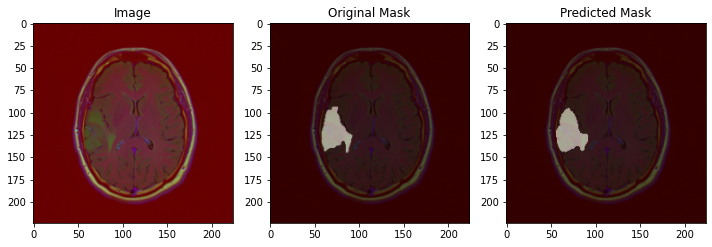

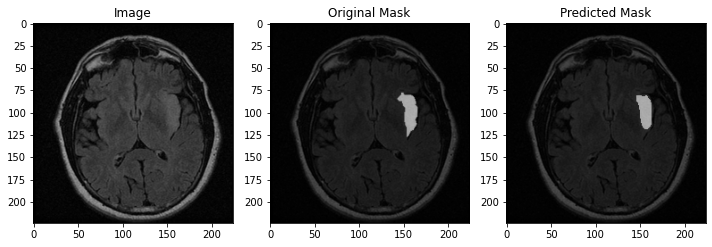

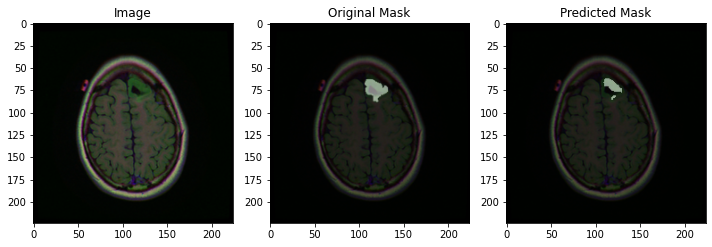

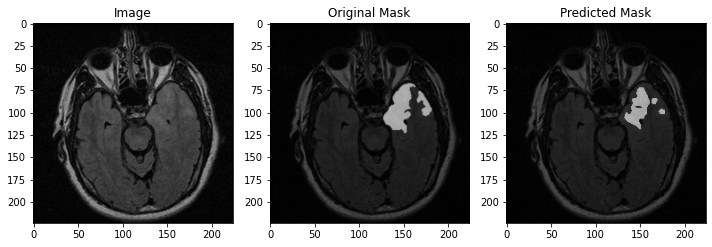

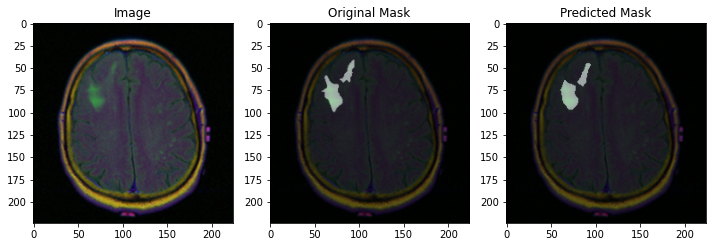

In [41]:
for _ in range(5):
    test_plot(model)

## [Baseline Results](https://www.kaggle.com/code/pankratozzi/segformer-with-pytorch?scriptVersionId=110767297)